In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wasifalwazed","key":"21ba70521af6aa169580e3a9169fa410"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nightfury007/ham10000-isic2018-raw

Dataset URL: https://www.kaggle.com/datasets/nightfury007/ham10000-isic2018-raw
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 2.98G/2.98G [02:15<00:00, 23.8MB/s]
100% 2.98G/2.98G [02:15<00:00, 23.6MB/s]


In [ ]:
!unzip ham10000-isic2018-raw

Streaming output truncated to the last 5000 lines.
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030834_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030835_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030836_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030837_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030838_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030839_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030840_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030841_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentations_lesion_tschandl/ISIC_0030842_segmentation.png  
  inflating: dataverse_files/HAM10000_segmentatio

# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

# Data Paths

In [ ]:
metadata_path = "dataverse_files/HAM10000_metadata"
images_folder = "dataverse_files/HAM10000_images_combined_600x450"

# Mapping Image Paths with CSV File

In [ ]:
metadata = pd.read_csv(metadata_path)

metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(images_folder, f"{x}.jpg"))
metadata['file_exists'] = metadata['image_path'].apply(os.path.exists)
assert metadata['file_exists'].all(), "Some image files are missing!"

# Map labels to integers
label_mapping = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label_mapping)

# Split into train, validation, and test sets

In [ ]:
train_metadata, test_metadata = train_test_split(
    metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
val_metadata, test_metadata = train_test_split(
    test_metadata, test_size=0.5, stratify=test_metadata['label'], random_state=42)

# Preprocessing function

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    return np.array(image) / 255.0

In [ ]:
# Load data function
def load_data(metadata_df):
    images, labels = [], []
    for _, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
        images.append(preprocess_image(row['image_path']))
        labels.append(row['label'])
    return np.array(images), to_categorical(labels, num_classes=len(label_mapping))

# Prepare datasets

In [ ]:
train_images, train_labels = load_data(train_metadata)
val_images, val_labels = load_data(val_metadata)
test_images, test_labels = load_data(test_metadata)

100%|██████████| 1002/1002 [00:09<00:00, 107.33it/s]


# Data augmentation

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# ResNet50

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_mapping), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## Hyperparameters

In [ ]:
batch_size = 32
lr_mode = 'cos'
epochs = 50

# Learning rate scheduler

In [ ]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

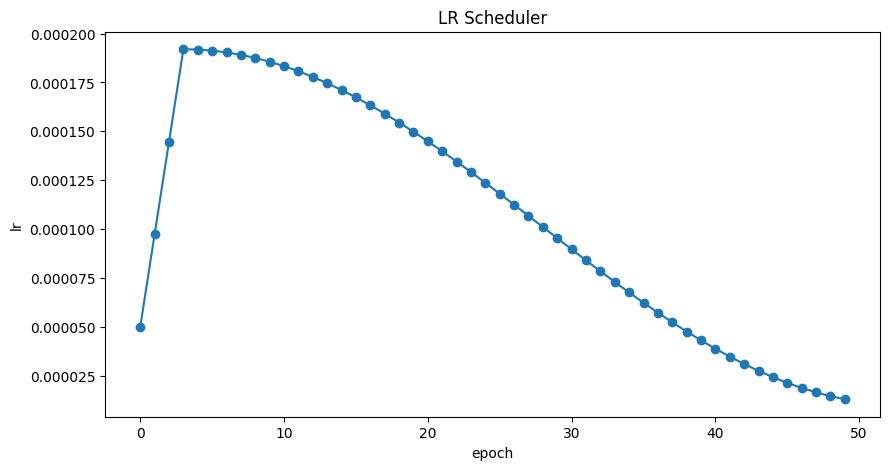

In [ ]:
lr_cb = get_lr_callback(batch_size=batch_size, mode=lr_mode, plot=True, epochs=epochs)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Training the Model

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    data_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=(val_images, val_labels),
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 104s 355ms/step - accuracy: 0.4125 - loss: 1.9764 - val_accuracy: 0.6693 - val_loss: 1.1450 - learning_rate: 5.0000e-05
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.5988 - loss: 1.3946 - val_accuracy: 0.6693 - val_loss: 1.1662 - learning_rate: 9.7333e-05
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.6581 - loss: 1.2562 - val_accuracy: 0.6693 - val_loss: 1.2268 - learning_rate: 1.4467e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 297ms/step - accuracy: 0.6705 - loss: 1.1998 - val_accuracy: 0.6693 - val_loss: 1.3160 - learning_rate: 1.9200e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.6709 - loss: 1.1910 - val_accuracy: 0.6693 - val_loss: 1.2589 - learning_rate: 1.9182e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 296ms/step - accuracy: 0.6667 - loss: 1.2023 - val_accuracy: 0.6693 - val_loss: 1.2691 - learning_rate: 1.9128e-04


## Fine-tune the model

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_finetune = model.fit(
    data_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=(val_images, val_labels),
    verbose=1
)

Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 417ms/step - accuracy: 0.6641 - loss: 0.9953 - val_accuracy: 0.6274 - val_loss: 2.6534 - learning_rate: 5.0000e-05
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.7510 - loss: 0.7131 - val_accuracy: 0.6693 - val_loss: 4.7073 - learning_rate: 9.7333e-05
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 297ms/step - accuracy: 0.7947 - loss: 0.6028 - val_accuracy: 0.6713 - val_loss: 1.9985 - learning_rate: 1.4467e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 299ms/step - accuracy: 0.8003 - loss: 0.5491 - val_accuracy: 0.6713 - val_loss: 1.0194 - learning_rate: 1.9200e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 297ms/step - accuracy: 0.8164 - loss: 0.4994 - val_accuracy: 0.7433 - val_loss: 0.6997 - learning_rate: 1.9182e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.8442 - loss: 0.4471 - val_accuracy: 0.8172 - val_loss: 0.5430 - learning_rate: 1.9128e-04
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 2

# Evaluate

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8228 - loss: 0.5683
Test Accuracy: 82.14%
